# Test Sentiment Analysis

In [1]:
import datetime
import copy as c
import random
import collections
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
#!pip install afinn
from afinn import Afinn
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

In [2]:
#On récupère directement le dataset nettoyé
url_local=r"C:\Users\Antoine\Downloads\clean_ecb_speeches_dataset.csv"
df=pd.read_csv(url_local,sep = ",",encoding='utf-8')

In [3]:
df

,date,speakers,title,subtitle,contents,Year,Month,Day,DayofWeek,DayofWeek_str,Month_str
0,2021-11-29,Christine Lagarde,Dialogue in a changing world,"Lectio Magistralis by Christine Lagarde, Presi...",SPEECH Dialogue in a changing world Lect...,2021,11,29,1,Monday,November
1,2021-11-26,Christine Lagarde,Change and continuity in law,"Keynote speech by Christine Lagarde, President...",SPEECH Change and continuity in law Keyn...,2021,11,26,5,Friday,November
2,2021-11-25,Frank Elderson,When you need change to preserve continuity: c...,"Speech by Frank Elderson, Member of the Execut...",SPEECH When you need change to preserve co...,2021,11,25,4,Thursday,November
3,2021-11-24,Fabio Panetta,Patient monetary policy amid a rocky recovery,"Speech by Fabio Panetta, Member of the Executi...",SPEECH Patient monetary policy amid a rock...,2021,11,24,3,Wednesday,November
4,2021-11-22,Luis de Guindos,Ralph Koijen’s contribution to research on the...,"Remarks by Luis de Guindos, Vice-President of ...",SPEECH Ralph Koijen’s contribution to rese...,2021,11,22,1,Monday,November
...,...,...,...,...,...,...,...,...,...,...,...
2325,1997-05-13,Alexandre Lamfalussy,The European Central Bank: independent and acc...,Keynote speech delivered by Alexandre Lamfalus...,The European Central Bank: independent and a...,1997,5,13,2,Tuesday,May
2326,1997-04-30,Alexandre Lamfalussy,The operation of monetary policy in stage thre...,"Address by Alexandre Lamfalussy, President of ...",The operation of monetary policy in stage th...,1997,4,30,3,Wednesday,April
2327,1997-04-22,Alexandre Lamfalussy,Convergence and the role of the European Centr...,"Remarks by Alexandre Lamfalussy, President of ...",Convergence and the role of the European Cen...,1997,4,22,2,Tuesday,April
2328,1997-03-10,Alexandre Lamfalussy,Securing the benefits of EMU,"Address by Alexandre Lamfalussy, President of ...",Securing the benefits of EMU Address by Al...,1997,3,10,1,Monday,March


In [4]:
# https://ednafernandes.medium.com/three-python-libraries-for-sentiment-analysis-c189655e0d9b
#Article intéressant pour 3 librairies classiques/basiques pour l'analyse de sentiments
# TextBlob
# AFINN
# Vader

## AFINN

In [5]:
afinn = Afinn()
#exemple :
afinn.score('This is utterly excellent!')

3.0

In [6]:
"""from afinn import Afinn
def afinn_polarity(text):
    return Afinn().score(text)
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['polarity'] = df[text].apply(afinn_polarity)
df['classification'] = df['polarity'].apply(getAnalysis)"""

"from afinn import Afinn\ndef afinn_polarity(text):\n    return Afinn().score(text)\ndef getAnalysis(score):\n    if score < 0:\n        return 'Negative'\n    elif score == 0:\n        return 'Neutral'\n    else:\n        return 'Positive'\ndf['polarity'] = df[text].apply(afinn_polarity)\ndf['classification'] = df['polarity'].apply(getAnalysis)"

In [7]:
#Premier test du score AFINN
start = time.time()
N=random.randrange(0, len(df))
print("Score :", afinn.score(df["contents"][N]))
end = time.time()
print("Temps pris :", end-start)
#Une première estimation donne une durée totale d'analyse d'un peu plus de 6 minutes pour tous les discours

Score : 62.0
Temps pris : 0.10372185707092285


In [8]:
start = time.time()

df["afinn-score"]=pd.Series(dtype=int)
def afinn_score(text):
    return afinn.score(text)

df["afinn-score"]=df["contents"].apply(afinn_score)

end = time.time()
print("Temps pris :", end-start) #~3 minutes

Temps pris : 207.44267988204956


Score moyen : 91.8656652360515
Score médian : 85.0


<AxesSubplot:>

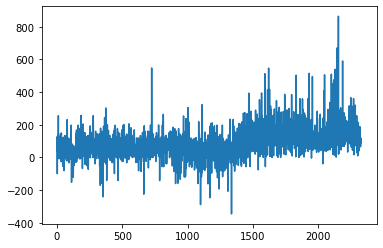

In [9]:
print("Score moyen :", df["afinn-score"].mean())
print("Score médian :",df["afinn-score"].median())

df["afinn-score"].plot()

## TextBlob

In [10]:
"""from textblob import TextBlob
def textblob_polarity(text):
 return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
df['polarity'] = df[text].apply(textblob_polarity)
df['classification'] = df['polarity'].apply(getAnalysis)"""

"from textblob import TextBlob\ndef textblob_polarity(text):\n return TextBlob(text).sentiment.polarity\ndef getAnalysis(score):\n    if score < 0:\n        return 'Negative'\n    elif score == 0:\n        return 'Neutral'\n    else:\n        return 'Positive'\ndf['polarity'] = df[text].apply(textblob_polarity)\ndf['classification'] = df['polarity'].apply(getAnalysis)"

In [11]:
start = time.time()

df["textblob-score"]=pd.Series(dtype=int)
def textblob_score(text):
    return TextBlob(text).sentiment.polarity

df["textblob-score"]=df["contents"].apply(textblob_score)

end = time.time()
print("Temps pris :", end-start) #~40 secondes

Temps pris : 36.762694358825684


Score moyen : 0.10475803863429205
Score médian : 0.1012273260839259


<AxesSubplot:>

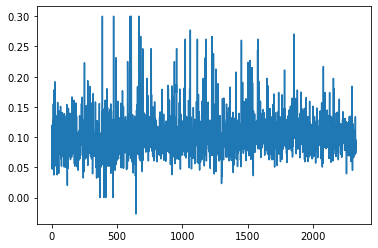

In [14]:
print("Score moyen :", df["textblob-score"].mean())
print("Score médian :",df["textblob-score"].median())

df["textblob-score"].plot()

## Vader Sentiment Lexicon

In [27]:
"""from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
def varder_polarity(text):
    return SentimentIntensityAnalyzer().polarity_scores(text)
def varder_analysis(score):
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.5:
        return 'Negative'
    else:
        return 'Neutral'
df['polarity'] = df[text].apply(varder_analysis)
df['classification'] = df['polarity'].apply(varder_analysis)"""

"from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer\ndef varder_polarity(text):\n    return SentimentIntensityAnalyzer().polarity_scores(text)\ndef varder_analysis(score):\n    if score['compound'] >= 0.05:\n        return 'Positive'\n    elif score['compound'] <= -0.5:\n        return 'Negative'\n    else:\n        return 'Neutral'\ndf['polarity'] = df[text].apply(varder_analysis)\ndf['classification'] = df['polarity'].apply(varder_analysis)"

In [ ]:
start = time.time()

# Exemple de résultat de de modèle
# {'neg': 0.029, 'neu': 0.878, 'pos': 0.092, 'compound': 0.9999}
df["vader-score"]=pd.Series(dtype=int)

def vader_score(text):
    #retourne un dictionnaire
    return SentimentIntensityAnalyzer().polarity_scores(text)

def vader_score_compound(text):
    #retourne un float
    return SentimentIntensityAnalyzer().polarity_scores(text)['compound']

df["vader-score"]=df["contents"].apply(vader_score_compound)

end = time.time()
print("Temps pris :", end-start) #22 minutes pour vader_score

In [ ]:
print("Score moyen :", df["vader-score"].mean())
print("Score médian :",df["vader-score"].median())

df["vader-score"].plot()